In [1]:
from pathlib import Path
import time
import datetime
from tqdm import tqdm
from collections import defaultdict, Counter
import copy
import random
import re
import numpy as np
import os
from sklearn.metrics import roc_auc_score
import pickle
from datetime import datetime 
import math
import uncertainty_toolbox as utc

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
    
from model import NRMS
from dataloader import TrainDataset, NewsDataset, UserDataset
from policy import CB_sim

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device("cuda:0")
torch.cuda.set_device(device)

In [3]:
dataset = 'demo/'

data_path = Path("/home/v-mezhang/blob/data/" + str(dataset) + "utils/")
model_path = Path("/home/v-mezhang/blob/model/" + str(dataset))

date_format_str = '%m/%d/%Y %I:%M:%S %p'

# sys.stdout = open(model_path / 'output.txt', "w")
# print(model_path)
# sys.stdout.flush()

In [4]:
npratio = 4
max_his_len = 50
min_word_cnt = 3
max_title_len = 30

In [5]:
batch_size = 32
epoch = 1
lr=0.0001
name = 'nrms_' + dataset[:-1]
retrain = False
online_flag = False
offline_flag = False
cb_flag = True
eva_times = 2

# collect impressions

In [6]:
with open(data_path/'train_sam_uid.pkl', 'rb') as f:
    train_sam = pickle.load(f)

with open(data_path/'sorted_train_sam_uid.pkl', 'rb') as f:
    sorted_train_sam = pickle.load(f)
    
with open(data_path/'sorted_valid_sam_uid.pkl', 'rb') as f:
    valid_sam = pickle.load(f)

if os.path.exists(data_path/'test_sam_uid.pkl'):    
    with open(data_path/'test_sam_uid.pkl', 'rb') as f:
        test_sam = pickle.load(f)

# News Preprocess

In [7]:
with open(data_path/'nid2index.pkl', 'rb') as f:
    nid2index = pickle.load(f)
    
with open(data_path/'vocab_dict.pkl', 'rb') as f:
    vocab_dict = pickle.load(f)

embedding_matrix = np.load(data_path/'embedding.npy')
news_index = np.load(data_path /'news_index.npy')

In [8]:
if os.path.exists(data_path/'test_nid2index.pkl'):
    with open(data_path/'test_nid2index.pkl', 'rb') as f:
        test_nid2index = pickle.load(f)

    test_news_index = np.load(data_path /'test_news_index.npy')
else: # TODO: for now use valid to do test (cb)
    test_nid2index = nid2index
    test_news_index = news_index
    test_sam = valid_sam

In [9]:
def cal_ctr(samples, news_click_count, news_impr_count, interval_time,):
    for l in tqdm(samples):
        pos, neg, his, uid, tsp = l
        tsp = datetime.strptime(tsp,date_format_str)
        tidx = int((tsp - start_time).total_seconds()/interval_time) 
        if type(pos) is list:
            for i in pos:
                nidx = nid2index[i]
                news_click_count[nidx, tidx] += 1
                news_impr_count[nidx, tidx] += 1
        else:
            nidx = nid2index[pos]
            news_click_count[nidx, tidx] += 1
            news_impr_count[nidx, tidx] += 1

        for i in neg:
            nidx = nid2index[i]
            news_impr_count[nidx, tidx] += 1
    return news_click_count, news_impr_count

# News Pool

In [10]:

interval_time = 3600
start_time =  datetime.strptime(sorted_train_sam[0][-1],date_format_str)
# print(start_time)
end_time = datetime.strptime(valid_sam[-1][-1],date_format_str)
nt = int((end_time - start_time).total_seconds()/interval_time) + 1 
print(len(nid2index))
print(nt)
news_click_count = np.zeros((len(nid2index), nt), dtype=float)
news_impr_count = np.ones((len(nid2index), nt), dtype=float) * 100 # assume 100 times init

news_click_count, news_impr_count = cal_ctr(train_sam, news_click_count, news_impr_count, interval_time)
news_click_count, news_impr_count = cal_ctr(valid_sam, news_click_count, news_impr_count, interval_time)

28604
168


100%|██████████| 7538/7538 [00:00<00:00, 31213.05it/s]


In [11]:
# news_ctr = np.zeros_like(news_click_count)
# for i in tqdm(range(news_click_count.shape[0])):
#     for j in range(news_click_count.shape[1]):
#         if news_impr_count[i,j] == 0:
#             assert news_click_count[i,j] == 0
#             news_ctr[i,j] = 0
#         else:
#             news_ctr[i,j] = news_click_count[i,j]/news_impr_count[i,j]
news_ctr = news_click_count/news_impr_count

In [12]:
import matplotlib.pyplot as plt
# news_ctr = news_click_count/news_impr_count
# plt.imshow(news_ctr[:,166])
# plt.colorbar()
tidx = 111
nonzero = news_ctr[:,tidx][news_ctr[:, tidx] > 0]
len(nonzero)

104

(array([29., 25., 33., 19., 11.,  7., 12., 18., 10.,  4.]),
 array([ 15. ,  38.5,  62. ,  85.5, 109. , 132.5, 156. , 179.5, 203. ,
        226.5, 250. ]),
 <BarContainer object of 10 artists>)

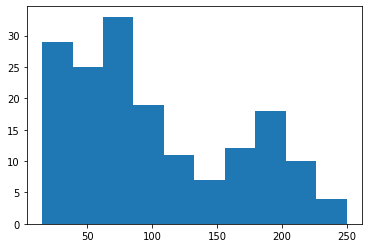

In [13]:
nonzero_count = []
for i in range(news_click_count.shape[1]):
    nonzero = news_ctr[:,i][news_ctr[:, i] > 0]
    nonzero_count.append(len(nonzero))
plt.hist(nonzero_count)

# Train

In [14]:
def dcg_score(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10):
    best = dcg_score(y_true, y_true, k)
    actual = dcg_score(y_true, y_score, k)
    return actual / best


def mrr_score(y_true, y_score):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)
    rr_score = y_true / (np.arange(len(y_true)) + 1)
    return np.sum(rr_score) / np.sum(y_true)

In [15]:
def compute_amn(y_true, y_score):
    auc = roc_auc_score(y_true,y_score)
    mrr = mrr_score(y_true,y_score)
    ndcg5 = ndcg_score(y_true,y_score,5)
    ndcg10 = ndcg_score(y_true,y_score,10)
    return auc, mrr, ndcg5, ndcg10

def evaluation_split(news_vecs, user_vecs, samples, nid2index):
    all_rslt = []
    for i in tqdm(range(len(samples))):
        poss, negs, _, _, _ = samples[i]
        user_vec = user_vecs[i]
        y_true = [1] * len(poss) + [0] * len(negs)
        news_ids = [nid2index[i] for i in poss + negs]
        news_vec = news_vecs[news_ids]
        y_score = np.multiply(news_vec, user_vec)
        y_score = np.sum(y_score, axis=1)
        try:
            all_rslt.append(compute_amn(y_true, y_score))
        except Exception as e:
            print(e)
    return np.array(all_rslt)

In [16]:
train_ds = TrainDataset(train_sam, nid2index, news_index)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [17]:
if retrain:
    for time in range(1):
        model = NRMS().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        best_auc = 0
        for ep in range(epoch):
            loss = 0
            accuary = 0.0
            model.train()
            train_loader = tqdm(train_dl)
            for cnt, batch_sample in enumerate(train_loader):
                candidate_news_index, his_index, label = batch_sample
                sample_num = candidate_news_index.shape[0]
                candidate_news_index = candidate_news_index.to(device)
                his_index = his_index.to(device)
                label = label.to(device)
                bz_loss, y_hat = model(candidate_news_index, his_index, label)

                loss += bz_loss.detach().cpu().numpy()
                optimizer.zero_grad()
                bz_loss.backward()

                optimizer.step()

                if cnt % 10 == 0:
                    train_loader.set_description(f"[{cnt}]steps loss: {loss / (cnt+1):.4f} ")
                    train_loader.refresh() 


            model.eval()
            news_dl = DataLoader(news_dataset, batch_size=1024, shuffle=False, num_workers=0)
            news_vecs = []
            for news in tqdm(news_dl):
                news = news.to(device)
                news_vec = model.text_encoder(news).detach().cpu().numpy()
                news_vecs.append(news_vec)
            news_vecs = np.concatenate(news_vecs)

            user_dataset = UserDataset(valid_sam, news_vecs, nid2index)
            user_vecs = []
            user_dl = DataLoader(user_dataset, batch_size=1024, shuffle=False, num_workers=0)
            for his, tsp in tqdm(user_dl):
                his = his.to(device)
                user_vec = model.user_encoder(his).detach().cpu().numpy()
                user_vecs.append(user_vec)
            user_vecs = np.concatenate(user_vecs)

            val_scores = evaluation_split(news_vecs, user_vecs, valid_sam, nid2index)
            val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*val_scores))]
            print(f"[{ep}] epoch auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}")

            with open(model_path/f'{name}.txt', 'a') as f:
                f.write(f"[{ep}] epoch auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")
                    
            if val_auc > best_auc:
                best_auc = val_auc
                torch.save(model.state_dict(), model_path/f'{name}.pkl')
                with open(model_path/f'{name}.txt', 'a') as f:
                    f.write(f"[{ep}] epoch save model\n")
            

In [18]:
def print_eva_metric(y_scores, y_trues):
    all_rslt_mean = []
    all_rslt_ucb1 = []
    all_rslt_ucb05 = []
    all_rslt_ucb15 = []

    for key, value in y_scores.items():
        mean = np.asarray(value).mean(axis = 0)
        std = np.asarray(value).std(axis = 0)
        # print(utc.metrics.get_all_metrics(mean, std, np.array(y_trues[key])))
        try:
            all_rslt_mean.append(compute_amn(y_trues[key], mean))
            all_rslt_ucb1.append(compute_amn(y_trues[key], mean + std ))
            all_rslt_ucb05.append(compute_amn(y_trues[key], mean + 0.5 * std ))
            all_rslt_ucb15.append(compute_amn(y_trues[key], mean + 1.5 * std ))
        except Exception as e:
            print(e)


    val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*np.array(all_rslt_mean)))]
    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"ucb 0 auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")

    val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*np.array(all_rslt_ucb05)))]
    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"ucb 0.5 auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")
        
    val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*np.array(all_rslt_ucb1)))]
    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"ucb 1 auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n")
   
    val_auc, val_mrr, val_ndcg, val_ndcg10 = [np.mean(i) for i in list(zip(*np.array(all_rslt_ucb15)))]
    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"ucb 1.5 auc: {val_auc:.4f}, mrr: {val_mrr:.4f}, ndcg5: {val_ndcg:.4f}, ndcg10: {val_ndcg10:.4f}\n \n")


# Offline

In [19]:
# offline 

if offline_flag:
    model = NRMS().to(device)
    model.load_state_dict(torch.load(model_path/f'{name}.pkl'))
    model.eval()
    for m in model.modules():
        if m.__class__.__name__.startswith('dropout'):
            print(m)
            m.train()

    y_scores = defaultdict(list)
    y_trues = {}

    with torch.no_grad():

        for i in tqdm(range(eva_times)):
            test_news_dataset = NewsDataset(test_news_index)
            news_dl = DataLoader(test_news_dataset, batch_size=1024, shuffle=False, num_workers=0)
            news_vecs = []
            for news in tqdm(news_dl):
                news = news.to(device)
                news_vec = model.text_encoder(news).detach().cpu().numpy()
                news_vecs.append(news_vec)
            news_vecs = np.concatenate(news_vecs)

            user_dataset = UserDataset(test_sam, news_vecs, test_nid2index)
            user_vecs = []
            user_dl = DataLoader(user_dataset, batch_size=1024, shuffle=False, num_workers=0)
            for his_tsp in tqdm(user_dl):
                his, _ = his_tsp
                his = his.to(device)
                user_vec = model.user_encoder(his).detach().cpu().numpy()
                user_vecs.append(user_vec)
            user_vecs = np.concatenate(user_vecs)

            for i in tqdm(range(len(valid_sam))):
                poss, negs, _, _, _ = valid_sam[i]
                user_vec = user_vecs[i]
                y_true = [1] * len(poss) + [0] * len(negs)
                news_ids = [nid2index[i] for i in poss + negs]
                news_vec = news_vecs[news_ids]
                y_score = np.multiply(news_vec, user_vec)
                y_score = np.sum(y_score, axis=1)
                
                y_scores[i].append(y_score)
                y_trues[i] = y_true

    with open(model_path/f'{name}.txt', 'a') as f:
        f.write(f"offline eva with eva : {eva_times} times\n")
    print_eva_metric(y_scores, y_trues)

    # test_auc, test_mrr, test_ndcg, test_ndcg10 = [np.mean(i) for i in list(zip(*test_scores))]
    # print(f"[{i}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}")

# with open(model_path/ f'{name}.txt', 'a') as f:
#         f.write(f"[{time}] time test auc: {test_auc:.4f}, mrr: {test_mrr:.4f}, ndcg5: {test_ndcg:.4f}, ndcg10: {test_ndcg10:.4f}\n")

# Online

In [20]:
def construct_trainable_samples(samples):
    tr_samples = []
    for l in samples:
        pos_imp, neg_imp, his, uid, tsp = l    
        for pos in list(pos_imp):
            tr_samples.append([pos, neg_imp, his, uid, tsp])
    return tr_samples



def finetune(model, ft_sam, nid2index, news_index, batch_size):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ft_sam = construct_trainable_samples(ft_sam)
    ft_ds = TrainDataset(ft_sam, nid2index, news_index)
    ft_dl = DataLoader(ft_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    for ep in range(epoch):
        loss = 0
        accuary = 0.0
        model.train()
        ft_loader = tqdm(ft_dl)
        for cnt, batch_sample in enumerate(ft_loader):
            candidate_news_index, his_index, label = batch_sample
            sample_num = candidate_news_index.shape[0]
            candidate_news_index = candidate_news_index.to(device)
            his_index = his_index.to(device)
            label = label.to(device)
            bz_loss, y_hat = model(candidate_news_index, his_index, label)

            loss += bz_loss.detach().cpu().numpy()
            optimizer.zero_grad()
            bz_loss.backward()

            optimizer.step()

            if cnt % 10 == 0:
                ft_loader.set_description(f"[{cnt}]steps loss: {loss / (cnt+1):.4f} ")
                ft_loader.refresh() 

    return model 

def eva_batch(model, droupout_flag, batch_news_index, batch_sam, batch_nid2index, y_scores, y_trues, ucbs, batch_size, batch_id):
    model.eval()
    if droupout_flag:
        for m in model.modules():
            if m.__class__.__name__.startswith('dropout'):
                print(m)
                m.train()
    
    with torch.no_grad():
        for i in tqdm(range(eva_times)):
            batch_news_dataset = NewsDataset(batch_news_index)
            news_dl = DataLoader(batch_news_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            news_vecs = []
            for news in tqdm(news_dl):
                news = news.to(device)
                news_vec = model.text_encoder(news).detach().cpu().numpy()
                news_vecs.append(news_vec)
            news_vecs = np.concatenate(news_vecs)

            user_dataset = UserDataset(batch_sam, news_vecs, batch_nid2index)
            user_vecs = []
            user_dl = DataLoader(user_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            

            for his_tsp in tqdm(user_dl):
                his, tsp = his_tsp
                batch_time = datetime.strptime(str(tsp[-1]), date_format_str)
                his = his.to(device)
                user_vec = model.user_encoder(his).detach().cpu().numpy()
                user_vecs.append(user_vec)
                # print(tsp)
            user_vecs = np.concatenate(user_vecs)

            start_id = batch_size * batch_id

            for i in tqdm(range(len(batch_sam))):
                poss, negs, _, _,_ = batch_sam[i]
                user_vec = user_vecs[i]
                y_true = [1] * len(poss) + [0] * len(negs)
                news_ids = [nid2index[i] for i in poss + negs]
                news_vec = news_vecs[news_ids]
                y_score = np.multiply(news_vec, user_vec)
                y_score = np.sum(y_score, axis=1)
                
                y_scores[start_id+i].append(y_score)
                y_trues[start_id+i] = y_true
                
    return y_scores, y_trues, batch_time

In [21]:
# online 

if online_flag:

    print('online eva')

    model = NRMS().to(device)
    model.load_state_dict(torch.load(model_path/f'{name}.pkl'))

    y_scores = defaultdict(list)
    y_trues = {}

    update_time = None
    update_batch = 0
    batch_size = 1024
    dropout_flag = True

    n_batch = math.ceil(float(len(test_sam))/batch_size)

    for i in range(n_batch):
        upper_range = min(1024 * (i+1), len(test_sam))
        batch_sam = test_sam[1024 * i: upper_range]

        y_scores, y_trues, batch_time = eva_batch(model, dropout_flag, test_news_index, batch_sam, test_nid2index, y_scores, y_trues, batch_size, i)
        
        num_sample = len(y_scores)
        with open(model_path/f'{name}.txt', 'a') as f:
            f.write(f"online eva on batch : {i} with {num_sample} samples in current batch, up to index {upper_range}\n")
        print_eva_metric(y_scores, y_trues)
    
        if update_time is None:
            update_time = batch_time
            print('init update time: ', update_time)
        if (batch_time- update_time).total_seconds() > 3600:

            ft_sam = test_sam[1024 * update_batch: upper_range]
            if upper_range - 1024 * update_batch > 512:
                print('finetune with: '  + str(1024 * update_batch) + ' ~ ' + str(upper_range))
                model = finetune(model=model, ft_sam=ft_sam, nid2index=test_nid2index, news_index=test_news_index, batch_size=32)

                update_time = batch_time
                update_batch = i + 1
                print('update before: ', update_time)
            else: 
                print('no finetune due to insufficient samples: ', str(upper_range - 1024 * update_batch))

    torch.save(model.state_dict(), model_path/f'{name}_finetune.pkl')
# sys.stdout.close()

# Bandit Simulation

In [22]:
for para in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(para)
    cb_sim = CB_sim(model_path=model_path, simulator_path=model_path, out_path=model_path, device=device, news_index=test_news_index, nid2index=test_nid2index, embedding_matrix = embedding_matrix, 
    news_ctr = news_ctr, start_time = start_time, interval_time = interval_time,
    lr = lr, epoch = epoch, name = name)
    cb_sim.run_exper(test_sam=test_sam, num_exper=2, n_inference = 2, policy='epsilon_greedy', policy_para=para)

0


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


init time:  2019-11-15 00:00:13
finetune with: 0 ~ 1024


  0%|          | 0/95 [00:00<?, ?it/s]


NameError: name 'max_his_len' is not defined

In [ ]:
num_exper, num_sam = cb_sim.rewards.shape
cumu_regrets = np.zeros((num_exper, num_sam))
for i in range(num_exper):
    cumu_reward = 0
    cumu_opt_reward = 0

    for j in range(num_sam):
        cumu_reward += cb_sim.rewards[i,j]
        cumu_opt_reward += cb_sim.opt_rewards[i,j]
        cumu_regrets[i,j] = (cumu_opt_reward - cumu_reward)/(j+1)

In [ ]:
plt.plot(range(num_sam), cumu_regrets.mean(axis=0))

In [ ]:
plt.hist(cb_sim.rewards.mean(axis = 0))

In [ ]:
plt.hist(cb_sim.opt_rewards.mean(axis = 0))